## Plant Disease Detection

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [2]:
PATH = "data/dogscats/"
sz = 224
arch = resnet34
bs = 16

In [3]:
m = arch(True)

In [4]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [5]:
children(m)[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   

In [6]:
nn.Conv2d?

In [7]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 38, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [8]:
PATH = 'data/plantvillage/crowdai/'

In [9]:
ls {PATH}

models/  pato_1._crop.jpeg*  pato_1.jpeg*  tmp/  train/  val/


In [10]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, val_name='val')

In [11]:
len(data.classes)

38

In [12]:
learn = ConvLearner.from_model_data(m, data)

In [13]:
learn.freeze_to(-4)

In [14]:
m[-1].trainable

True

In [15]:
m[-4].trainable

True

In [16]:
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      3.506402   2.087343   0.834375  



[2.087343, 0.834375]

In [17]:
learn.fit(0.01, 3, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      1.292518   0.947678   0.917812  
    1      0.778892   0.563964   0.9375                        
    2      1.946899   1.198555   0.90875                      
    3      1.006928   0.731137   0.933125                      
    4      0.572249   0.625084   0.936875                      
    5      0.484367   0.417696   0.952812                      
    6      1.742979   1.072708   0.918438                     
    7      1.779605   1.25667    0.910625                     
    8      1.427014   1.317691   0.908438                     
    9      0.923929   0.902471   0.924688                      
    10     0.683371   0.675829   0.944062                      
    11     0.705377   0.508433   0.954688                      
    12     0.623283   0.413869   0.960625                      
    13     0.394258   0.395575   0.960938                      



[0.39557508, 0.9609375]

## CAM

In [18]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = to_np(output)
    def remove(self): self.hook.remove()

In [39]:
x,y = next(iter(data.val_dl))
x,y = x[None,14], y[None,14]

vx = Variable(x.cuda(), requires_grad=True)

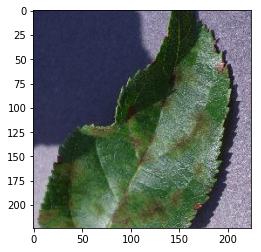

In [40]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [21]:
sf = SaveFeatures(m[-4])
py = m(Variable(x.cuda()))
sf.remove()

py = np.exp(to_np(py)[0]); py

array([0.99566, 0.     , 0.     , 0.00434, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     ], dtype=float32)

In [22]:
feat = np.maximum(0, sf.features[0])
feat.shape

(38, 7, 7)

In [23]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.52962, 0.70443, 0.50702, 0.31577, 0.3487 , 0.50894, 0.37284],
       [0.75772, 1.     , 0.76229, 0.54828, 0.61856, 0.79665, 0.57862],
       [0.61348, 0.84626, 0.67594, 0.51023, 0.60355, 0.73331, 0.51836],
       [0.33605, 0.56104, 0.50826, 0.43378, 0.52128, 0.6301 , 0.44233],
       [0.15528, 0.39551, 0.4621 , 0.44841, 0.53986, 0.71978, 0.56179],
       [0.07489, 0.32374, 0.46233, 0.4962 , 0.60231, 0.82564, 0.6844 ],
       [0.     , 0.18503, 0.29776, 0.33379, 0.41819, 0.58623, 0.4887 ]], dtype=float32)

/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


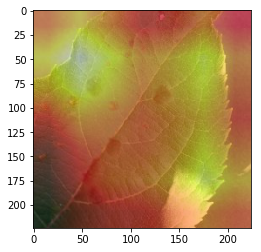

In [24]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

## Model

In [26]:
learn.unfreeze()
learn.bn_freeze(True)

In [27]:
lr=np.array([1e-6,1e-4,1e-2])

In [28]:
learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.464802   0.374661   0.962188  
    1      0.419078   0.354435   0.962188                      



[0.35443538, 0.9621875]

In [31]:
def accuracy(preds, targs):
    preds = torch.from_numpy(preds)
    targs = torch.from_numpy(targs)
    preds = torch.max(preds, dim=1)[1]
    return (preds==targs).float().mean()

log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy(probs, y)

0.980625

In [32]:
learn.fit(lr, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.52955    0.357501   0.961875  
    1      0.342675   0.352012   0.965625                      
    2      0.442487   0.371958   0.965                         
    3      0.3407     0.368954   0.965625                      



[0.36895448, 0.965625]

In [33]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy(probs, y)

0.979375

In [41]:
learn.save('lesson7-CAM-test-96')